## Importing All Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. GOOGLE (GOOGL) Stock Price Dataset

In [2]:
df = yf.download('GOOGL', start='2004-08-19', end=datetime.today())

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2004-08-19 00:00:00+00:00,2.504808,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20 00:00:00+00:00,2.703765,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23 00:00:00+00:00,2.730976,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24 00:00:00+00:00,2.617892,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25 00:00:00+00:00,2.646101,2.652653,2.702703,2.599600,2.626627,183772044


In [4]:
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2024-10-29 00:00:00+00:00,169.679993,169.679993,170.380005,167.089996,167.729996,42169000
2024-10-30 00:00:00+00:00,174.460007,174.460007,182.020004,174.059998,180.679993,68890800
2024-10-31 00:00:00+00:00,171.110001,171.110001,176.820007,171.000000,173.130005,44769000
2024-11-01 00:00:00+00:00,171.289993,171.289993,172.320007,168.880005,170.070007,31773700
2024-11-04 00:00:00+00:00,169.169998,169.169998,170.729996,168.088593,170.029999,7469006


In [5]:
df.duplicated().sum()

0

In [6]:
df.columns = df.columns.get_level_values(0)
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-08-19 00:00:00+00:00,2.504808,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20 00:00:00+00:00,2.703765,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23 00:00:00+00:00,2.730976,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24 00:00:00+00:00,2.617892,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25 00:00:00+00:00,2.646101,2.652653,2.702703,2.599600,2.626627,183772044
...,...,...,...,...,...,...
2024-10-29 00:00:00+00:00,169.679993,169.679993,170.380005,167.089996,167.729996,42169000
2024-10-30 00:00:00+00:00,174.460007,174.460007,182.020004,174.059998,180.679993,68890800
2024-10-31 00:00:00+00:00,171.110001,171.110001,176.820007,171.000000,173.130005,44769000


## Copying the dataset for future use

In [7]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

### Dropping unwanted column

In [8]:
df.drop(['Adj Close'], axis=1, inplace=True)

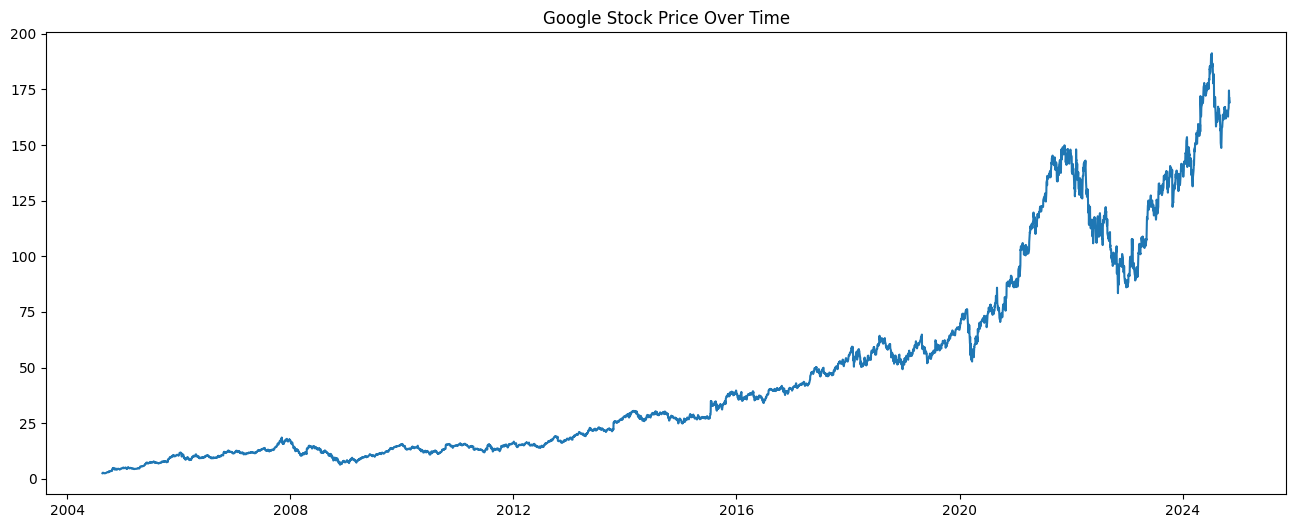

In [9]:
# Visualize the close price
plt.figure(figsize=(16,6))
plt.plot(df['Close'])
plt.title('Google Stock Price Over Time')
plt.show()

### Check the data is stationary or not
## ADF test
We are using Augumented Dickey Fuller (ADF) test to eck if the price series is stationary.
The null hypothesis of the ADF test is that the time series is non-stationary. So if the p-value of the test is less than the significance level (0.05) than we can reject the null hypothesisband infer that the tim series is indeed stationary.

In [10]:
# Perform ADF test
result = adfuller(df['Close'].dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'No. of lags used: {result[2]}')
print(f'Number of observations used: {result[3]}')

ADF Statistic: 1.4124251416538298
p-value: 0.9971698627626311
No. of lags used: 31
Number of observations used: 5056


### Auto-correlation function (ACF)

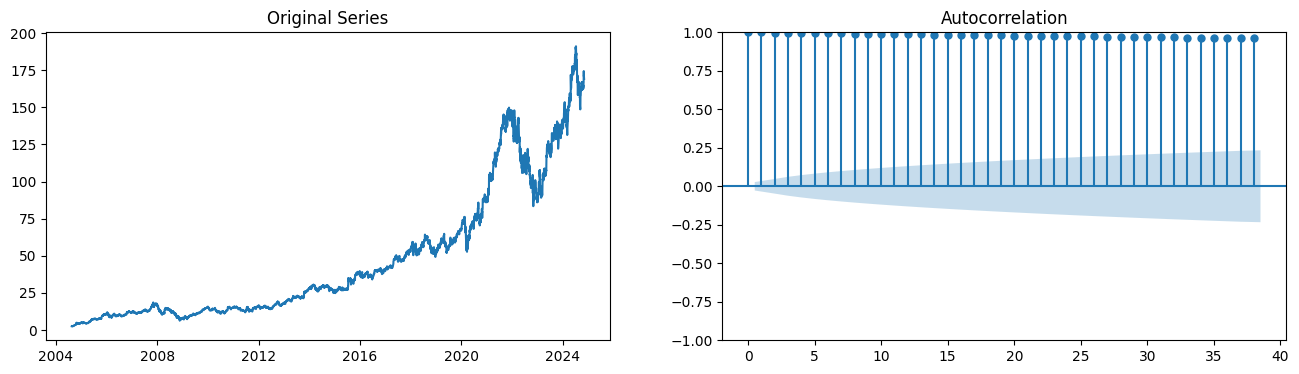

In [11]:
# Plot ACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df['Close'])
ax1.set_title('Original Series')

plot_acf(df['Close'], ax=ax2);

## d
### Differencing the Data (If Not Stationary)

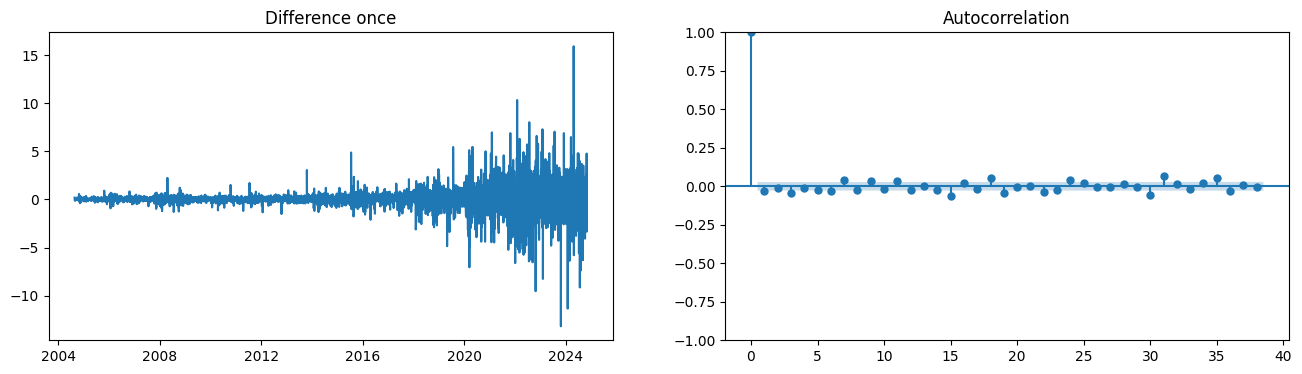

In [12]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference once')

plot_acf(diff, ax=ax2);

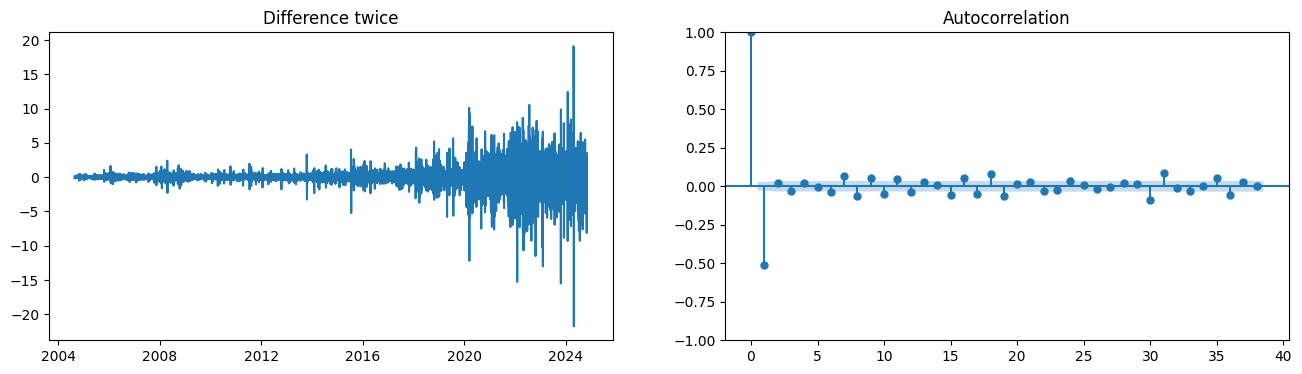

In [13]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference twice')

plot_acf(diff, ax=ax2);

We can use the pmdarima library to get the number of differencing like d required for our model.

In [14]:
ndiffs(df['Close'], test='adf')

1

## p
p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.

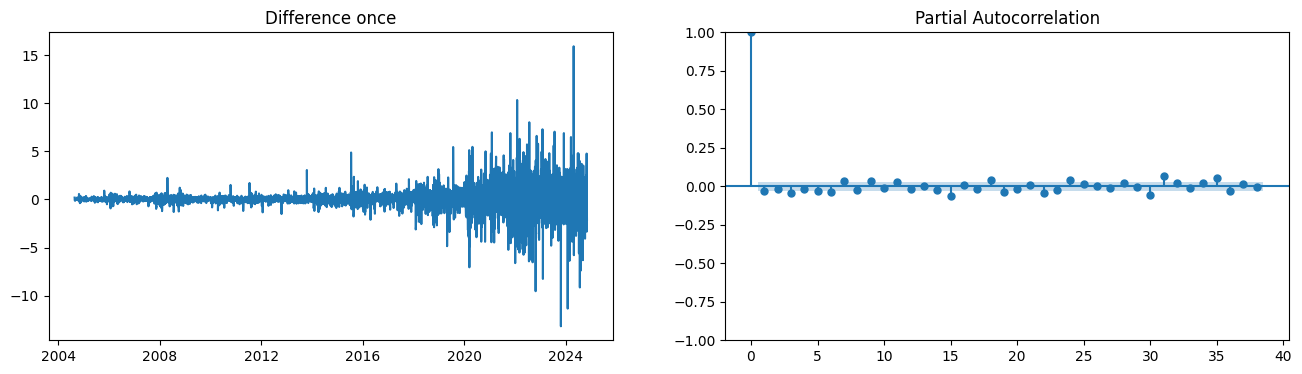

In [15]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

## q
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into ARIMA model.

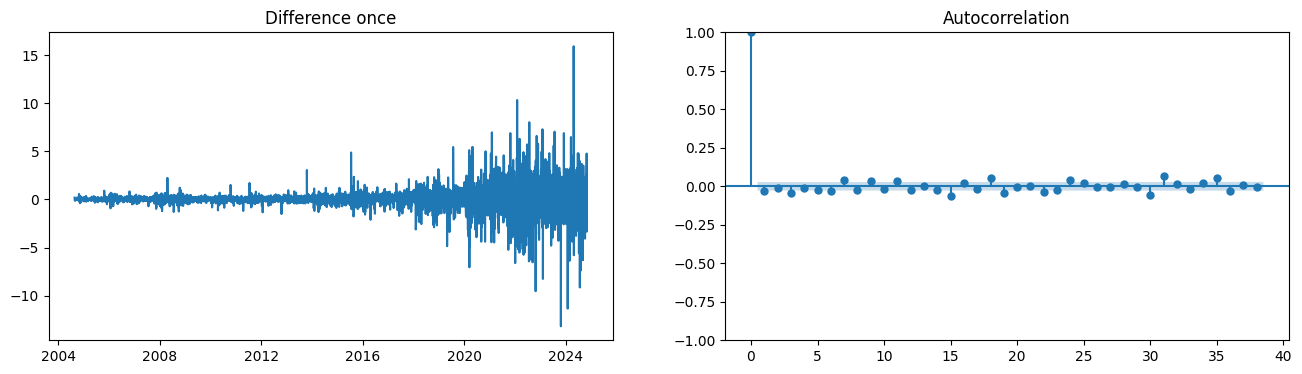

In [16]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

#Splitting the data into trrain set and test set

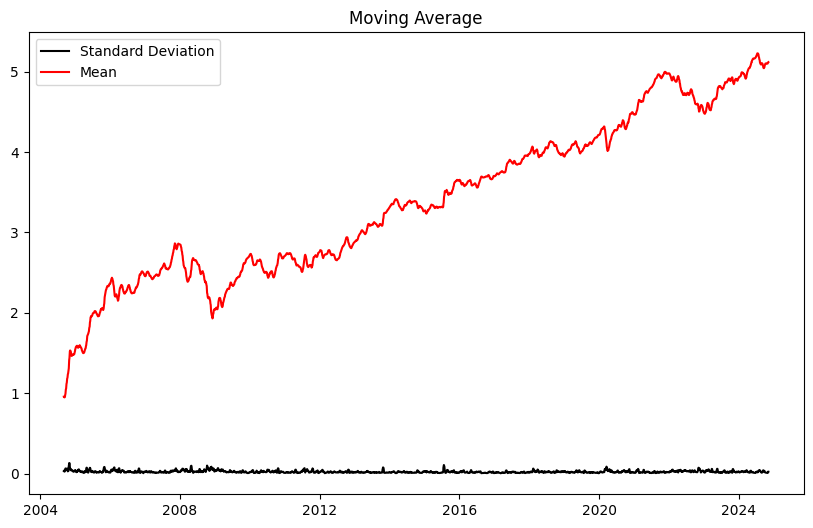

In [17]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_close = df['Close']
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

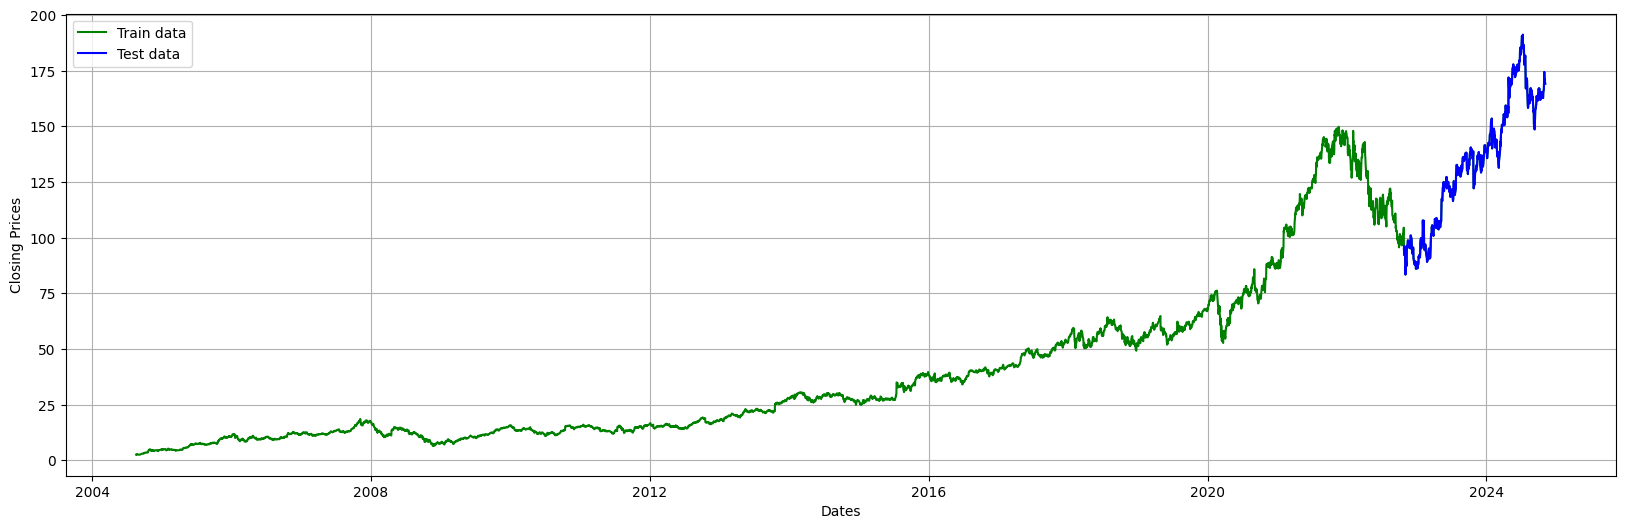

In [33]:
train_data, test_data = df_close[3:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(20,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### For p, d, q we can use the above method observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12257.236, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12236.686, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12237.356, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12257.895, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12237.466, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12234.878, Time=1.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12236.856, Time=3.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12236.851, Time=4.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12238.399, Time=0.95 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12229.446, Time=4.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=14.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12225.235, Time=7.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12223.412, Time=3.45 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=12226.904, Time=1.29 sec
 ARIMA(1,1,3)(0,0,0)[0] 

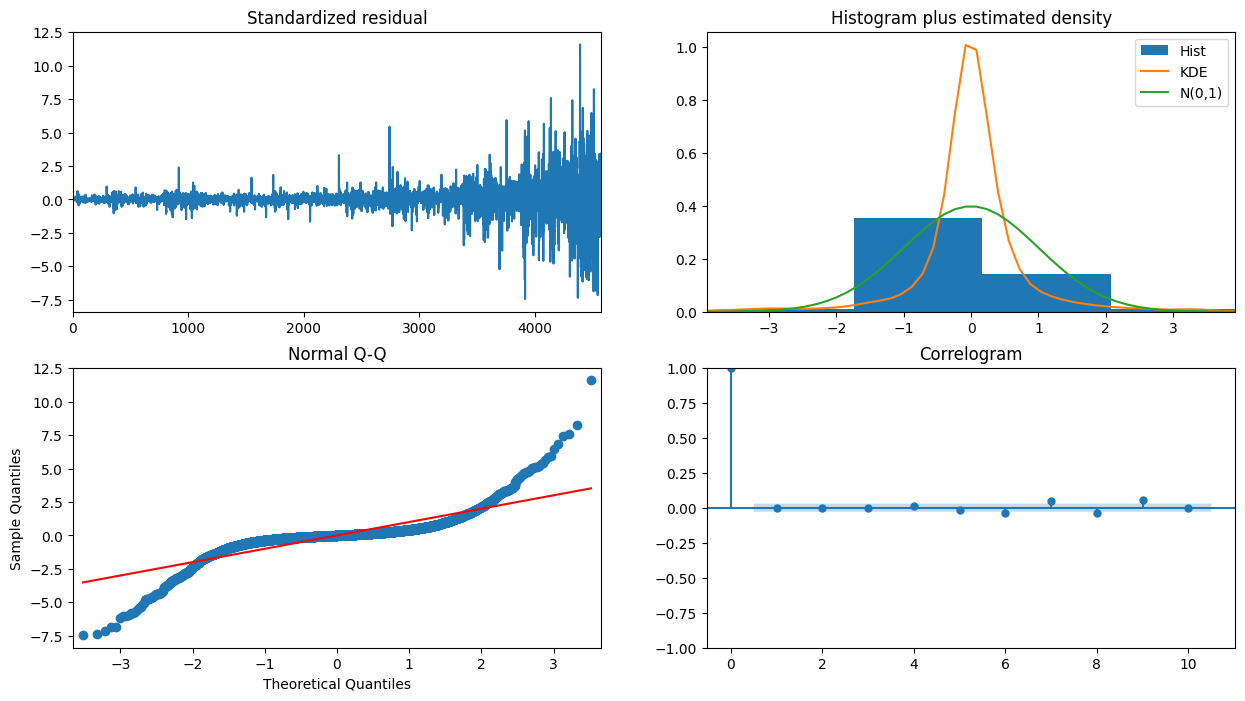

In [34]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

### Now fitting the model

In [35]:
model = ARIMA(train_data, order=(1, 1, 3)),
result = model.fit()

AttributeError: 'tuple' object has no attribute 'fit'

In [36]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4576
Model:                 ARIMA(1, 0, 1)   Log Likelihood               11608.310
Date:                Mon, 04 Nov 2024   AIC                         -23208.621
Time:                        16:35:41   BIC                         -23182.906
Sample:                             0   HQIC                        -23199.568
                               - 4576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2230      0.370      8.710      0.000       2.498       3.948
ar.L1          0.9994      0.000   4630.010      0.000       0.999       1.000
ma.L1         -0.0243      0.010     -2.463      0.0

In [37]:
fc = result.forecast(len(test_data))  # 95% conf
fc

,predicted_mean
4576,4.647620
4577,4.646736
4578,4.645852
4579,4.644969
4580,4.644087
...,...
5080,4.264907
5081,4.264260
5082,4.263614
5083,4.262968


In [38]:
test_data

,Close
Date,
2022-10-26 00:00:00+00:00,94.930000
2022-10-27 00:00:00+00:00,92.220001
2022-10-28 00:00:00+00:00,96.290001
2022-10-31 00:00:00+00:00,94.510002
2022-11-01 00:00:00+00:00,90.470001
...,...
2024-10-29 00:00:00+00:00,169.679993
2024-10-30 00:00:00+00:00,174.460007
2024-10-31 00:00:00+00:00,171.110001


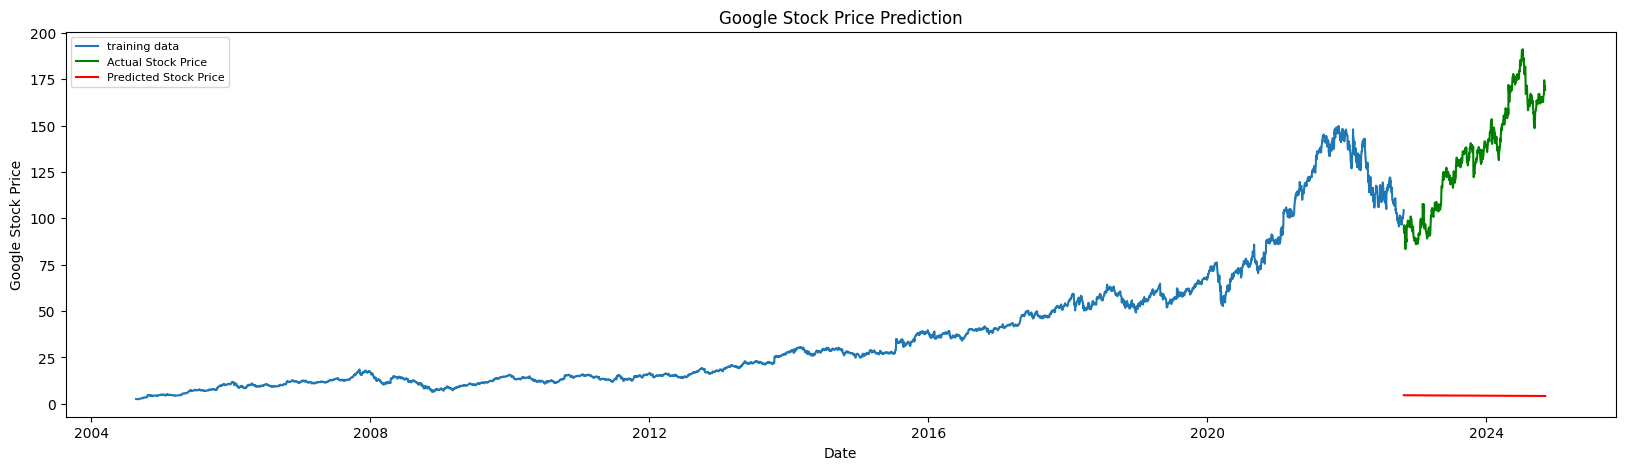

In [39]:
plt.figure(figsize=(20,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data.index, test_data, color = 'green', label='Actual Stock Price')
plt.plot(test_data.index, fc, color = 'red',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.10)
plt.title('Google Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Google Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
plt.show()

In [40]:
mse = mean_squared_error(test_data, fc)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, fc)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 17568.82200091745
Root Mean Squared Error: 132.5474330227389
Mean Absolute Error: 129.57004815665482
